In [1]:
import os
from numpy import *
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
# import mplleaflet 
# import folium
plt.style.use("seaborn-darkgrid")
# plt.style.use("dark_background") # dark bg plots
sns.set(style="ticks", context="talk")
# %matplotlib inline
# run for jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import tqdm
import json
import fiona
from shapely.geometry import shape 

In [2]:
# disable nonsensical pandas warning 
pd.options.mode.chained_assignment = None

### Folder Structure

In [3]:
#%% Read in data
root = '/home/alal/Dropbox/1_Research/India_Forests/'
code = root + 'Code'
data = root + 'Data'

In [4]:
%cd {data + '/Spatial/'}
%ls

/hdd/Dropbox/1_Research/India_Forests/Data/Spatial
create_border.qgz  deforestation.qgz  Processed/  Rasters/  Vectors/


## Ingest Buffers around Treated Blocks

In [3]:
path = '/home/users/asimoes/data/processed/'
block_buf = gpd.read_file("/home/users/asimoes/data/processed/BLOCKS_sch_coded.shp")
states    = gpd.read_file("/home/users/asimoes/data/vectors/IND_adm1.shp")

In [4]:
states['bound'] = states.boundary
states.geometry = states['bound']

In [5]:
block_buf[block_buf.state.isnull()]

,BLOCK_ID,NAME,DISTRICT,STATE_UT,C_CODE01,TOT_NM_HH,TOT_POP,M_POP,F_POP,TOT_L6,...,U_F_MRG_OT,U_TOT_NNW,U_M_NNW,U_F_NNW,named,nameb,state,sch,block_samp,geometry
0,2,Data Not Available,None,None,None,0,0,0,0,0,...,0,0,0,0,None,data not available,None,0,0,"POLYGON ((77.57774 35.39891, 77.57571 35.39656..."


In [6]:
block_buf.shape

(6348, 176)

In [7]:
block_buf = block_buf[~block_buf.state.isnull()]

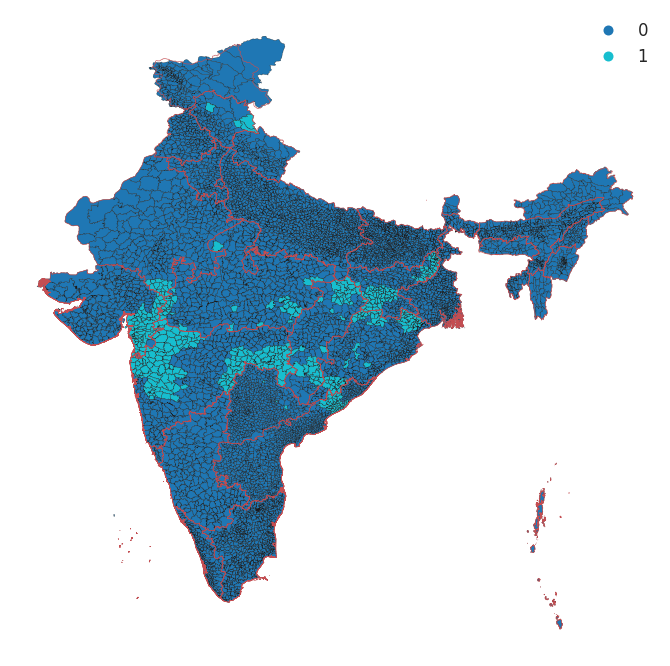

In [24]:
f, ax = plt.subplots(1, figsize=(12,12))
block_buf.plot(column='sch', categorical=True, legend=True, edgecolor='k',linewidth=0.3,ax=ax)
# block_error.plot(column='sch', categorical=True, legend=True, edgecolor='y',linewidth=0.3,ax=ax)
states.plot(edgecolor='r',linewidth=0.6,ax=ax)
ax.set_axis_off()

In [8]:
block_buf.total_bounds

array([68.11009 ,  6.755698, 97.4091  , 35.90731 ])

In [9]:
sort(block_buf.state.unique())

array(['Andaman & Nicobar', 'Arunachal  Pradesh', 'Assam', 'Bihar',
       'Chandigarh', 'Dadra & Nagar Haveli', 'Daman & Diu', 'Delhi',
       'Goa', 'Haryana', 'Jammu & Kashmir', 'Karnataka', 'Kerala',
       'Lakshdweep', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'Pondicherry', 'Punjab', 'Sikkim', 'Tamilnadu', 'Tripura',
       'Uttar Pradesh', 'Uttranchal', 'West Bengal', 'ap', 'ch', 'gu',
       'hp', 'jk', 'mh', 'mp', 'or', 'rj'], dtype=object)

In [10]:
sort(block_buf.STATE_UT.unique())

array(['Andaman & Nicobar', 'Andhra Pradesh', 'Arunachal  Pradesh',
       'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh',
       'Dadra & Nagar Haveli', 'Daman & Diu', 'Delhi', 'Goa', 'Gujarat',
       'Haryana', 'Himachal Pradesh', 'Jammu & Kashmir', 'Jharkhand',
       'Karnataka', 'Kerala', 'Lakshdweep', 'Madhya Pradesh',
       'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'Orissa', 'Pondicherry', 'Punjab', 'Rajasthan', 'Sikkim',
       'Tamilnadu', 'Tripura', 'Uttar Pradesh', 'Uttranchal',
       'West Bengal'], dtype=object)

# Dry Run: All Blocks 

In [8]:
#CELL FOR 2011
villages_path = '/home/users/asimoes/data/vectors/2011/2011_census/village_map/'

list_dirs = os.listdir(villages_path)

list_gdfs = []

for fold in list_dirs:
    list_files = os.listdir(villages_path+fold)
    
    list_files = [x.split('.')[0] for x in list_files]
    
    list_files = list(set(list_files))
    
    for fil in list_files:
        temp = gpd.read_file(villages_path+fold+'/'+fil+'.shp')
        list_gdfs.append(temp)

In [9]:
#Read data
def isvalid(geom):
    try:
        shape(geom)
        return 1
    except:
        return 0

def read_treat_error(path):
    collection = list(fiona.open(path,'r'))
    df1 = pd.DataFrame(collection)

    #Check Geometry
    df1['isvalid'] = df1['geometry'].apply(lambda x: isvalid(x))
    df1 = df1[df1['isvalid'] == 1]
    collection = json.loads(df1.to_json(orient='records'))

    #Convert to geodataframe
    gdf = gpd.GeoDataFrame.from_features(collection)
    
    return gdf

In [10]:
all_bloc = pd.concat(list_gdfs,sort=False,ignore_index=True)

In [25]:
all_bloc.to_file("/scratch/users/asimoes/data/processed/all_villages_bloc_2011_nofilter.gpkg",driver='GPKG')

In [11]:
all_bloc['area'] = all_bloc.geometry.area

In [12]:
all_bloc = all_bloc[all_bloc.area>0]#filter only villages with polygon geometry
all_bloc = all_bloc.sort_values('area',ascending=False)

In [13]:
all_bloc.drop_duplicates(['CODE_2011'],inplace=True)#filter only villages with largest area (for duplicates)

In [14]:
print (all_bloc.shape)

(615649, 131)


In [15]:
all_bloc = all_bloc[~all_bloc.CODE_2011.isnull()] #Filter only villages with CODE_2011

In [16]:
print (all_bloc.shape)

(615648, 131)


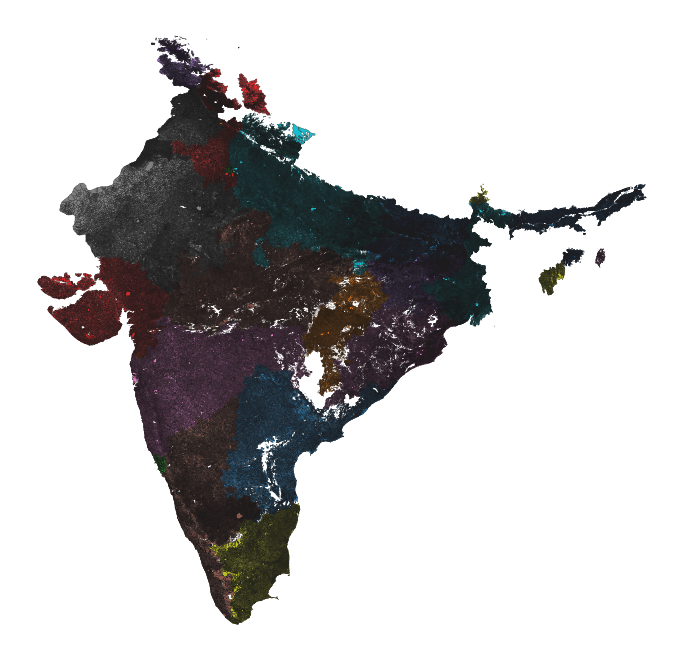

In [35]:
f, ax = plt.subplots(1, figsize=(12,12))
all_bloc.plot(column = 'STATE_UT', categorical=True, edgecolor='k',linewidth=0.3,ax=ax)
ax.set_axis_off()

In [ ]:
all_bloc.to_file("/scratch/users/asimoes/data/processed/all_villages_bloc_2011.shp")

## Spatial merge blocks and villages 

In [16]:
all_bloc = gpd.read_file("/scratch/users/asimoes/data/processed/all_villages_bloc_2011.shp")

In [17]:
all_bloc_centr = all_bloc.copy()
all_bloc_centr['centroid'] = all_bloc_centr.centroid
all_bloc_centr["x"] = all_bloc_centr.centroid.map(lambda p: p.x)
all_bloc_centr["y"] = all_bloc_centr.centroid.map(lambda p: p.y)
all_bloc_centr = all_bloc_centr.set_geometry('centroid')
all_bloc_centr.rename(columns={'geometry':'orig_geometry'},inplace=True)

Spatial Merge

In [18]:
#Merging on centroid (avoids many to many matching)
vil_treat_centr = gpd.sjoin(all_bloc_centr, 
                      block_buf.loc[:, ['sch', 'geometry']], how='inner', op='intersects')

In [19]:
all_bloc.shape
vil_treat_centr.shape

(615648, 131)

(615279, 136)

In [38]:
#Dropping centroid and returning to original geometry
vil_treat_centr.rename(columns={'orig_geometry':'geometry'},inplace=True)
vil_treat_centr = vil_treat_centr.set_geometry('geometry')
vil_treat_centr.drop(['centroid'], inplace = True, axis=1)

In [39]:
df1 = pd.DataFrame(vil_treat_centr)

def isvalid(geom):
    try:
        shape(geom)
        return 1
    except:
        return 0
    
df1['isvalid'] = df1.geometry.apply(lambda x: isvalid(x))

print (df1[df1['isvalid']==0].shape)

(0, 136)


In [ ]:
%%time
# vil_treat_centr.to_file("/scratch/users/asimoes/data/processed/all_villages_2011.gpkg", driver='GPKG')

In [ ]:
print ("ok")